Cats and dogs classification





In [ ]:

!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d chetankv/dogs-cats-images
!unzip dogs-cats-images.zip -d cats_dogs

串流輸出內容已截斷至最後 5000 行。
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.37.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.370.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3700.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3701.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3702.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3703.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3704.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3705.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3706.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3707.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3708.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.3709.jpg  
  inflating: cats_dogs/dog vs cat/dataset/training_set/cats/cat.371.jpg  
  inflat

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


BATCH_SIZE = 64
IMG_SIZE = (128, 128)

train_generator = train_datagen.flow_from_directory(
    '/content/cats_dogs/dataset/training_set/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # 二分类
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/cats_dogs/dataset/test_set/',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 6400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

# 预训练模型
base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# 自定义分类层
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 添加回调函数（早停 + 学习率衰减）
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]

# 开始训练
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8770 - auc: 0.9466 - loss: 0.2530 - val_accuracy: 0.9375 - val_auc: 0.9875 - val_loss: 0.1473 - learning_rate: 0.0010
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9598 - auc: 0.9929 - loss: 0.1068 - val_accuracy: 0.9575 - val_auc: 0.9916 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9606 - auc: 0.9940 - loss: 0.0990 - val_accuracy: 0.9450 - val_auc: 0.9919 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9660 - auc: 0.9952 - loss: 0.0879 - val_accuracy: 0.9500 - val_auc: 0.9903 - val_loss: 0.1258 - learning_rate: 0.0010
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9681 - auc: 0.9951 - loss: 0.0859 - val_accuracy: 0.9700 - val_auc: 0.9931 - val_loss: 0.0992 - learning_rate: 0.0010


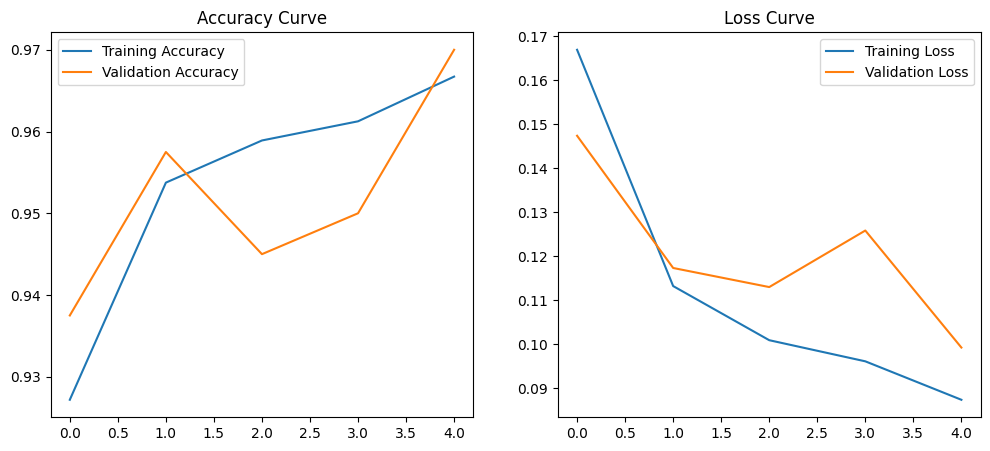

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       200
           1       0.50      0.50      0.50       200

    accuracy                           0.50       400
   macro avg       0.50      0.50      0.50       400
weighted avg       0.50      0.50      0.50       400



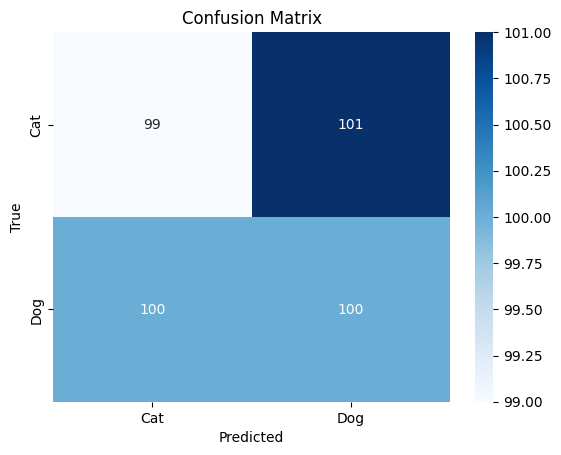

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 预测验证集
y_pred = model.predict(val_generator)
y_pred = (y_pred > 0.5).astype(int)

# 报告
print(classification_report(val_generator.classes, y_pred))

# 混淆矩阵
cm = confusion_matrix(val_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_11']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


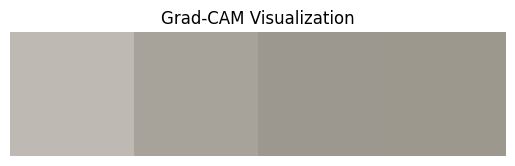

In [ ]:

import numpy as np

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[0]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(conv_outputs * weights, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

img_path = '/content/cats_dogs/dataset/training_set/dogs/dog.1001.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

heatmap = make_gradcam_heatmap(img_array, model, 'block_16_expand_relu')

plt.imshow(img_array[0])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Grad-CAM Visualization')
plt.show()

In [ ]:
model.save('cats_vs_dogs_project.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


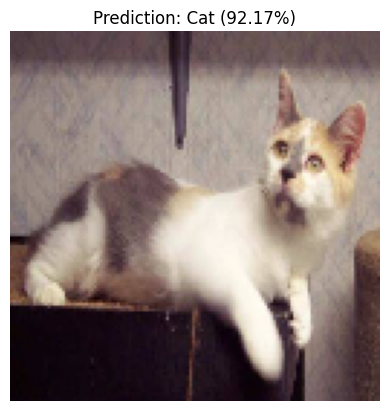

預測結果: Cat
置信度: 92.17%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


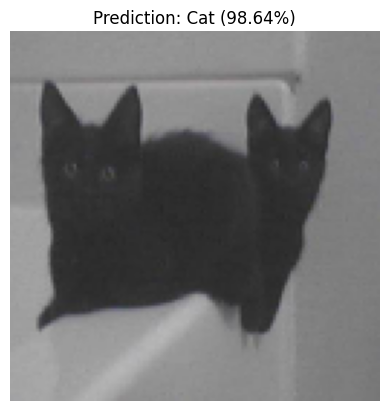

預測結果: Cat
置信度: 98.64%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


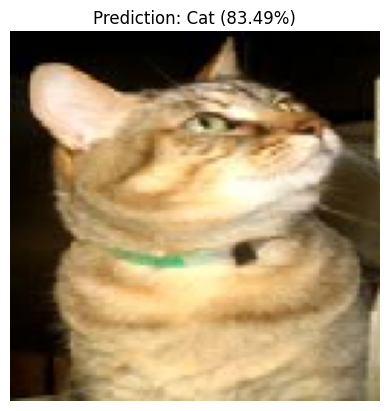

預測結果: Cat
置信度: 83.49%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


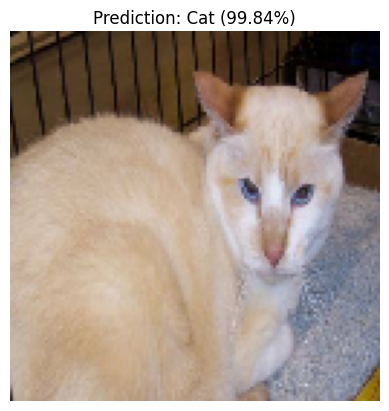

預測結果: Cat
置信度: 99.84%


In [ ]:

# 加載模型

from tensorflow.keras.models import load_model
model = load_model('cats_vs_dogs_project.h5')

# 定義預測函數
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_image(img_path, model, img_size=(128, 128)):
    """
    輸入圖片路徑，返回預測結果並可視化
    """
    # 加載圖片
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 預測
    pred = model.predict(img_array)[0][0]
    result = 'Dog' if pred > 0.5 else 'Cat'
    confidence = pred if result == 'Dog' else 1 - pred

    # 可視化
    plt.imshow(img)
    plt.title(f"Prediction: {result} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

    # 打印結果
    print(f"預測結果: {result}")
    print(f"置信度: {confidence:.2%}")

# 上傳圖片並預測
from google.colab import files

# 上傳圖片
img_path = '/content/cats_dogs/dog vs cat/dataset/training_set/cats/cat.1132.jpg'

# 進行預測
predict_image(img_path, model)
img_path = '/content/cats_dogs/dog vs cat/dataset/training_set/cats/cat.1210.jpg'
predict_image(img_path, model)
img_path = '/content/cats_dogs/dog vs cat/dataset/training_set/cats/cat.1347.jpg'
predict_image(img_path, model)
img_path = '/content/cats_dogs/dog vs cat/dataset/training_set/cats/cat.1495.jpg'
predict_image(img_path, model)

ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.11/dist-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.11/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.11/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(None, 150, 150, 3)




---



---



---



---



---



---



Cats and dogs classification grok ver

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 2000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 63/100 ━━━━━━━━━━━━━━━━━━━━ 1:15 2s/step - accuracy: 0.5122 - loss: 0.8265

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.5134 - loss: 0.7916 - val_accuracy: 0.5713 - val_loss: 0.6908
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.5419 - loss: 0.6879 - val_accuracy: 0.6019 - val_loss: 0.6798
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5661 - loss: 0.6839 - val_accuracy: 0.5419 - val_loss: 0.6874
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5711 - loss: 0.6820 - val_accuracy: 0.5594 - val_loss: 0.6844
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.5850 - loss: 0.6784 - val_accuracy: 0.5431 - val_loss: 0.6850
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.5589 - loss: 0.6837 - val_accuracy: 0.5131 - val_loss: 0.7409
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.5670 - loss: 0.6808 - val_accuracy: 0.5719 - val_loss: 0.6766
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5854 - loss: 0.6749 - val_accuracy: 0.576

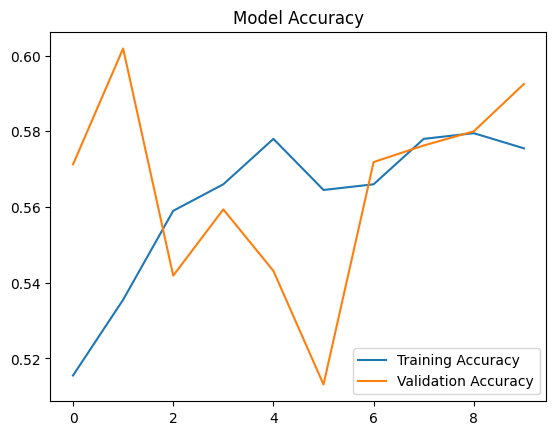

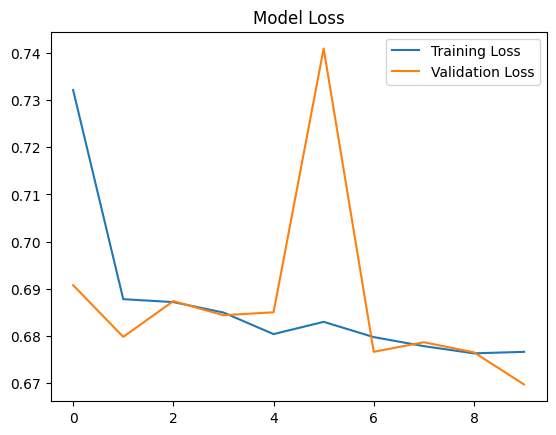

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/cats_dogs/dataset/test_set/', target_size=(150, 150), batch_size=32, class_mode='binary'
)
validation_generator = val_datagen.flow_from_directory(
    '/content/cats_dogs/dataset/training_set/', target_size=(150, 150), batch_size=32, class_mode='binary'
)

# Train the model
history = model.fit(
    train_generator, steps_per_epoch=100, epochs=10,
    validation_data=validation_generator, validation_steps=50
)

# Save the model
model.save('cats_dogs_classifier.h5')

# Plot results
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


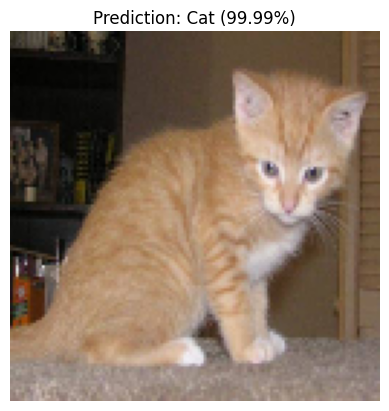

預測結果: Cat
置信度: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


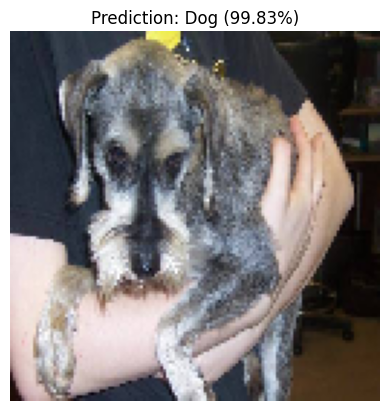

預測結果: Dog
置信度: 99.83%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


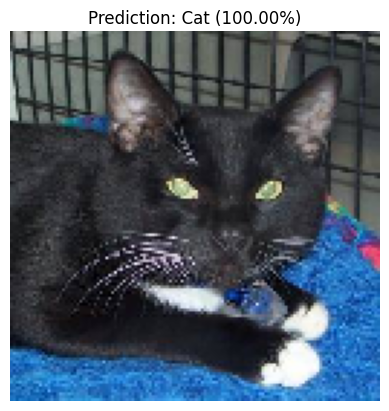

預測結果: Cat
置信度: 100.00%


In [ ]:

from tensorflow.keras.preprocessing import image
import numpy as np
def predict_image(img_path, model, img_size=(150, 150)):
    # 加載圖片
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # 預測
    pred = model.predict(img_array)[0][0]
    result = 'Dog' if pred > 0.5 else 'Cat'
    confidence = pred if result == 'Dog' else 1 - pred

    # 可視化
    plt.imshow(img)
    plt.title(f"Prediction: {result} ({confidence:.2%})")
    plt.axis('off')
    plt.show()


    print(f"預測結果: {result}")
    print(f"置信度: {confidence:.2%}")
img_path = '/content/cats_dogs/dataset/test_set/cats/cat.4003.jpg'

predict_image(img_path, model)
img_path = '/content/cats_dogs/dog vs cat/dataset/test_set/dogs/dog.4067.jpg'

predict_image(img_path, model)
img_path = '/content/cats_dogs/dog vs cat/dataset/test_set/cats/cat.4023.jpg'

predict_image(img_path, model)

img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0
prediction = model.predict(img_array)
print("Dog" if prediction[0] > 0.5 else "Cat")